In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 170M/170M [00:01<00:00, 94.6MB/s] 


In [4]:
latent_dim = 128

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.fc2 = nn.Linear(512, 32*32*3)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        x = torch.sigmoid(self.fc2(z))
        return x.view(-1, 3, 32, 32)


****AUTOENCODER (WITHOUT KL DIVERGENCE)****

In [6]:
class AE_Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, latent_dim)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = AE_Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [8]:
ae = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

epochs = 10

for epoch in range(epochs):
    ae.train()
    total_loss = 0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()

        x_recon = ae(x)
        loss = criterion(x_recon, x)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"AE Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(train_loader):.4f}")


AE Epoch [1/10] Loss: 0.0266
AE Epoch [2/10] Loss: 0.0156
AE Epoch [3/10] Loss: 0.0133
AE Epoch [4/10] Loss: 0.0120
AE Epoch [5/10] Loss: 0.0110
AE Epoch [6/10] Loss: 0.0104
AE Epoch [7/10] Loss: 0.0098
AE Epoch [8/10] Loss: 0.0107
AE Epoch [9/10] Loss: 0.0110
AE Epoch [10/10] Loss: 0.0093


****VARIATIONAL AUTOENCODER (WITH KL DIVERGENCE)****

In [9]:
class VAE_Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = torch.relu(self.fc1(x))
        return self.fc_mu(x), self.fc_logvar(x)


In [10]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


In [11]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VAE_Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


In [12]:
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = nn.MSELoss()(x_recon, x)
    kl_loss = -0.5 * torch.mean(
        1 + logvar - mu.pow(2) - logvar.exp()
    )
    return recon_loss + kl_loss


In [13]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

epochs = 15

for epoch in range(epochs):
    vae.train()
    total_loss = 0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()

        x_recon, mu, logvar = vae(x)
        loss = vae_loss(x_recon, x, mu, logvar)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"VAE Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(train_loader):.4f}")


VAE Epoch [1/15] Loss: 0.0637
VAE Epoch [2/15] Loss: 0.0623
VAE Epoch [3/15] Loss: 0.0622
VAE Epoch [4/15] Loss: 0.0622
VAE Epoch [5/15] Loss: 0.0621
VAE Epoch [6/15] Loss: 0.0621
VAE Epoch [7/15] Loss: 0.0621
VAE Epoch [8/15] Loss: 0.0621
VAE Epoch [9/15] Loss: 0.0621
VAE Epoch [10/15] Loss: 0.0621
VAE Epoch [11/15] Loss: 0.0621
VAE Epoch [12/15] Loss: 0.0621
VAE Epoch [13/15] Loss: 0.0621
VAE Epoch [14/15] Loss: 0.0621
VAE Epoch [15/15] Loss: 0.0621


In [14]:
def show_images(original, reconstructed, title):
    original = original.cpu()[:8]
    reconstructed = reconstructed.cpu()[:8]

    plt.figure(figsize=(12,4))
    for i in range(8):
        plt.subplot(2,8,i+1)
        plt.imshow(original[i].permute(1,2,0))
        plt.axis("off")

        plt.subplot(2,8,i+9)
        plt.imshow(reconstructed[i].permute(1,2,0))
        plt.axis("off")

    plt.suptitle(title)
    plt.show()


In [15]:
def reconstruction_accuracy(model, loader, is_vae=False):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)

            if is_vae:
                x_recon, _, _ = model(x)
            else:
                x_recon = model(x)

            loss = criterion(x_recon, x)
            total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    accuracy = (1 - avg_loss) * 100
    return avg_loss, accuracy


****BEFORE KL DIVERGENCE****

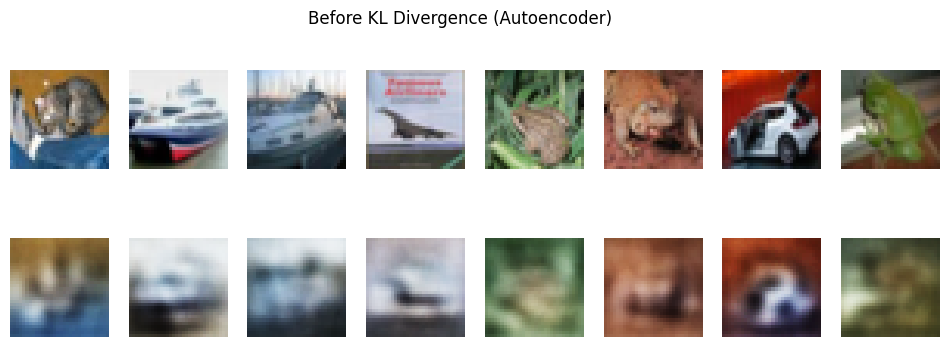

Before KL:
Loss: 0.009040074399377726
Accuracy: 99.09599256006223


In [16]:
x, _ = next(iter(test_loader))
x = x.to(device)

with torch.no_grad():
    x_recon = ae(x)

show_images(x, x_recon, "Before KL Divergence (Autoencoder)")

loss_before, acc_before = reconstruction_accuracy(ae, test_loader)
print("Before KL:")
print("Loss:", loss_before)
print("Accuracy:", acc_before)


****After KL Divergence****

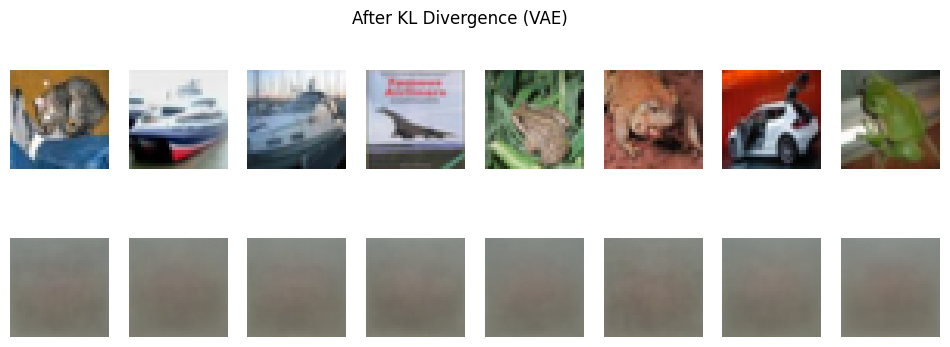

After KL:
Loss: 0.0619609412041646
Accuracy: 93.80390587958354


In [17]:
with torch.no_grad():
    x_recon, _, _ = vae(x)

show_images(x, x_recon, "After KL Divergence (VAE)")

loss_after, acc_after = reconstruction_accuracy(vae, test_loader, True)
print("After KL:")
print("Loss:", loss_after)
print("Accuracy:", acc_after)


In [18]:
results = pd.DataFrame({
    "Model": ["Without KL (AE)", "With KL (VAE)"],
    "Reconstruction Loss": [loss_before, loss_after],
    "Reconstruction Accuracy (%)": [acc_before, acc_after]
})

results


,Model,Reconstruction Loss,Reconstruction Accuracy (%)
0,Without KL (AE),0.009040,99.095993
1,With KL (VAE),0.061961,93.803906
